In [1]:
import qutip as qt
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

In [2]:
# Define the Hamiltonian
def Ham(Δ, Ω):
    return Δ*0.5*qt.sigmaz() + Ω*qt.sigmax()

Δ = 0
Nb = 0.2
Ω = γt = 1.0
H = Ham(Δ, Ω)
c_ops = [np.sqrt(γt*(Nb + 1))*qt.sigmam(), np.sqrt(γt*Nb)*qt.sigmap()]

# Compute steadystate
rhoss = qt.steadystate(H, c_ops)

def tilted_liouvillian(H, L_list, chi, v_list):
    """
    Constructs a tilted Liouvillian for a system with multiple jump operators and corresponding v values.

    Parameters:
    H : Qobj
        The Hamiltonian of the system.
    L_list : list of Qobj
        A list of jump operators.
    chi : float
        The tilt parameter.
    v_list : list of float
        A list of parameters that couple with chi, one for each jump operator.

    Returns:
    Qobj
        The tilted Liouvillian superoperator.
    """
    # Check that the number of jump operators matches the number of v values
    if len(L_list) != len(v_list):
        raise ValueError("The number of jump operators must match the number of v values.")
    
    # Hamiltonian part remains the same
    H_vec = qt.spre(H) - qt.spost(H)
    
    # Initialize the dissipative part
    L_vec_total = 0
    
    # Loop through all jump operators and their corresponding v values
    for L, v in zip(L_list, v_list):
        L_vec = np.exp(1j * chi * v) * qt.to_super(L) - 0.5 * (qt.spre(L.dag() * L) + qt.spost(L.dag() * L))
        L_vec_total += L_vec
    
    # Combine Hamiltonian and dissipative parts
    return -1j * H_vec + L_vec_total

rhoss

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.42971888+0.j         0.        -0.20080321j]
 [0.        +0.20080321j 0.57028112+0.j        ]]

In [43]:
# Compute vectorised density operator
rhovec = qt.operator_to_vector(rhoss)

# Create chi space
v = [-1, 1]
chi = np.linspace(-np.pi, np.pi, 1000)
d_chi = chi[1]-chi[0]

t = [5, 15, 30, 50]

# Compute tilted Liouvillians
liouvs = [tilted_liouvillian(H, c_ops, i, v) for i in chi]
rho_chi = [[qt.vector_to_operator((liou * ti).expm()*rhovec) for liou in liouvs] for ti in t]

# Take trace of all rhochis
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rho_chi])
# tilted_liouvillian(H, c_ops, chi[6], v)

In [44]:
#Compute n vals
nmax = 10
n = np.arange(-nmax-20, nmax+20 + 1)
# Peform Fourier transform
def prob(n):
    return np.abs([trapezoid(np.exp(-1j*ni*chi)*pchis, chi, dx=d_chi, axis=1) for ni in n])/(2*np.pi)

P = prob(np.arange(-nmax, nmax + 1))

while P[0, 1] + P[-1, 1] > 1e-13:
    P = np.vstack((
        prob(np.arange(-nmax - 10, -nmax)),
        P,
        prob(np.arange(nmax + 1, nmax + 11))
    ))
    nmax += 10

# Now fix n to match new P
n = np.arange(-nmax, nmax + 1)
P.T[0].shape == n.shape

True

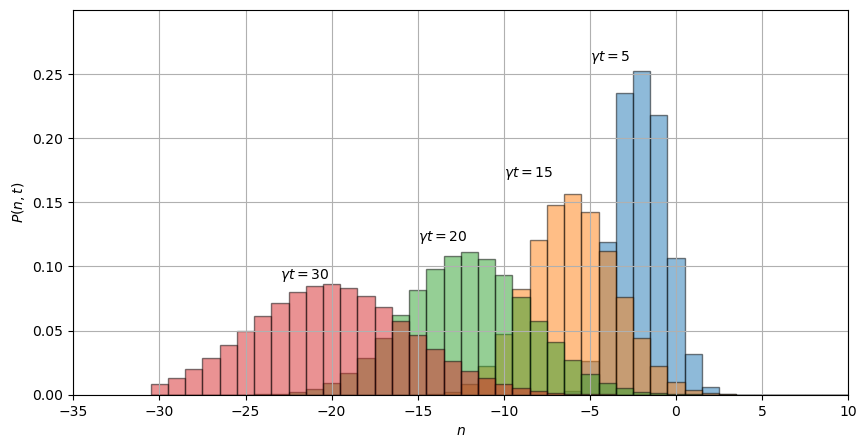

In [45]:
fig = plt.figure(figsize=(10, 5))

plt.bar(n, P.T[0], width = 1, alpha=0.5, edgecolor = 'k')
plt.bar(n, P.T[1], width = 1, alpha=0.5, edgecolor = 'k')
plt.bar(n, P.T[2], width = 1, alpha=0.5, edgecolor = 'k')
plt.bar(n, P.T[3], width = 1, alpha=0.5, edgecolor = 'k')

#plt.title('The FCS probability ' + r'$P(n, t)$,' + 'The negative count corresponds \nto the particle current flowing from cold to hot.')
plt.xlim([-35, 10])
plt.ylim([0, 0.30])
plt.yticks(np.arange(0, 0.30, 0.05))
plt.text(-5, 0.26, r'$\gamma t=5$')
plt.text(-10, 0.17, r'$\gamma t=15$')
plt.text(-15, 0.12, r'$\gamma t=20$')
plt.text(-23, 0.09, r'$\gamma t=30$')
plt.grid()
plt.xlabel(r'$n$')
plt.ylabel(r'$P(n,t)$')
plt.show()

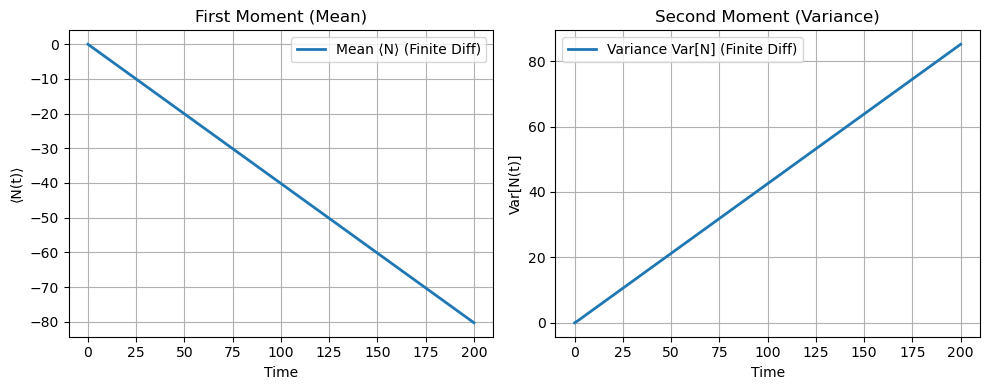

In [5]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Assume rhoss, H, c_ops are defined above this

rhovec = qt.operator_to_vector(rhoss)
v = [-1, 1]
chi = np.linspace(-np.pi, np.pi, 1000)
d_chi = chi[1] - chi[0]
t = np.linspace(0, 200, 200)

liouvs = [tilted_liouvillian(H, c_ops, ch, v) for ch in chi]
rho_chi = [[qt.vector_to_operator((liou * ti).expm() * rhovec) for liou in liouvs] for ti in t]
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rho_chi])
S_chi_t = np.log(np.maximum(pchis, 1e-10))

# Find index of chi=0
chi_0_index = np.argmin(np.abs(chi))

mean_fd = np.zeros(len(t), dtype=float)
var_fd = np.zeros(len(t), dtype=float)

for ti, S_vals in enumerate(S_chi_t):
    # Forward at start, backward at end, central elsewhere

    # First derivative
    if chi_0_index == 0:
        dS1 = (S_vals[1] - S_vals[0]) / (1j * d_chi)  # forward
    elif chi_0_index == len(chi) - 1:
        dS1 = (S_vals[-1] - S_vals[-2]) / (1j * d_chi)  # backward
    else:
        dS1 = (S_vals[chi_0_index + 1] - S_vals[chi_0_index - 1]) / (2 * 1j * d_chi)  # central

    # Second derivative
    if 1 <= chi_0_index <= len(chi) - 2:
        dS2 = (S_vals[chi_0_index + 1] - 2*S_vals[chi_0_index] + S_vals[chi_0_index - 1]) / (-(d_chi ** 2))  # central
    elif chi_0_index == 0:
        dS2 = (S_vals[2] - 2*S_vals[1] + S_vals[0]) / (-(d_chi ** 2))  # forward approximation
    else:
        dS2 = (S_vals[-1] - 2*S_vals[-2] + S_vals[-3]) / (-(d_chi ** 2))  # backward

    mean_fd[ti] = np.real(dS1)
    var_fd[ti] = np.real(dS2)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, mean_fd, label='Mean ⟨N⟩ (Finite Diff)', lw=2)
plt.xlabel("Time")
plt.ylabel("⟨N(t)⟩")
plt.title("First Moment (Mean)")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, var_fd, label='Variance Var[N] (Finite Diff)', lw=2)
plt.xlabel("Time")
plt.ylabel("Var[N(t)]")
plt.title("Second Moment (Variance)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


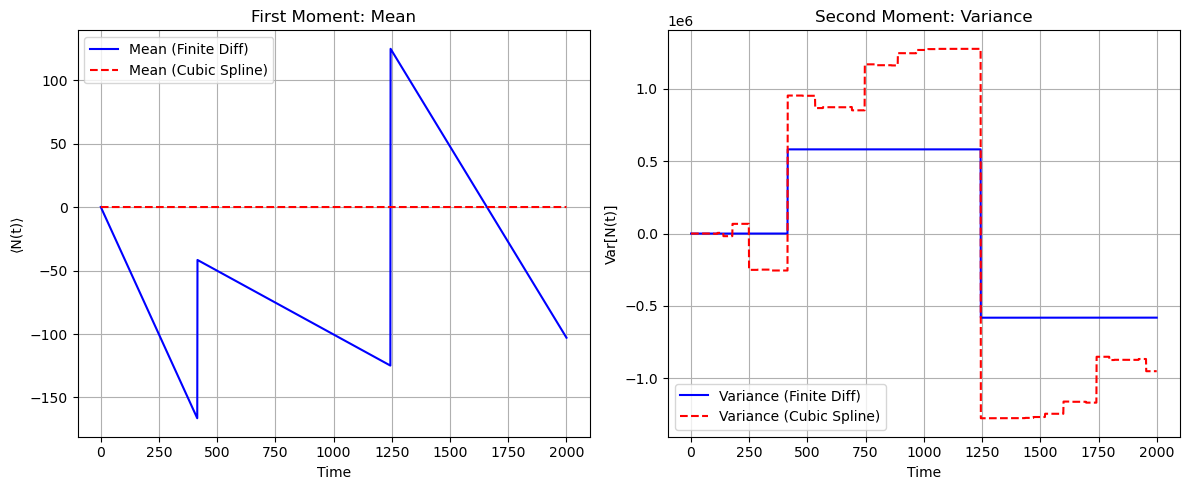

In [9]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# === Setup ===
rhovec = qt.operator_to_vector(rhoss)
v = [-1, 1]
chi = np.linspace(-np.pi, np.pi, 1000)
d_chi = chi[1] - chi[0]
t = np.linspace(0, 2000, 2000)

# Tilted Liouvillians
liouvs = [tilted_liouvillian(H, c_ops, ch, v) for ch in chi]
rho_chi = [[qt.vector_to_operator((liou * ti).expm() * rhovec) for liou in liouvs] for ti in t]
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rho_chi])
S_chi_t = np.log(np.maximum(pchis, 1e-10))  # Cumulant gen fn

chi_0_index = np.argmin(np.abs(chi))

# === Finite Difference Method ===
mean_fd = np.zeros(len(t))
var_fd = np.zeros(len(t))

for ti, S_vals in enumerate(S_chi_t):
    # First derivative (mean)
    if chi_0_index == 0:
        dS1 = (S_vals[1] - S_vals[0]) / (1j * d_chi)
    elif chi_0_index == len(chi) - 1:
        dS1 = (S_vals[-1] - S_vals[-2]) / (1j * d_chi)
    else:
        dS1 = (S_vals[chi_0_index + 1] - S_vals[chi_0_index - 1]) / (2 * 1j * d_chi)

    # Second derivative (variance)
    if 1 <= chi_0_index <= len(chi) - 2:
        dS2 = (S_vals[chi_0_index + 1] - 2*S_vals[chi_0_index] + S_vals[chi_0_index - 1]) / (-(d_chi ** 2))
    elif chi_0_index == 0:
        dS2 = (S_vals[2] - 2*S_vals[1] + S_vals[0]) / (-(d_chi ** 2))
    else:
        dS2 = (S_vals[-1] - 2*S_vals[-2] + S_vals[-3]) / (-(d_chi ** 2))

    mean_fd[ti] = np.real(dS1)
    var_fd[ti] = np.real(dS2)

# === Cubic Spline Method ===
mean_spline = np.zeros(len(t))
var_spline = np.zeros(len(t))

for ti, S_vals in enumerate(S_chi_t):
    spline = UnivariateSpline(chi, S_vals, s=0, k=3)  # Cubic spline
    spline_d1 = spline.derivative(n=1)
    spline_d2 = spline.derivative(n=2)
    mean_spline[ti] = np.real(spline_d1(0) / (1j))        # Mean ⟨N⟩
    var_spline[ti] = np.real(spline_d2(0) / (-(1)**2))    # Variance Var[N]

# === Plot Comparison ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, mean_fd, 'b-', label='Mean (Finite Diff)')
plt.plot(t, mean_spline, 'r--', label='Mean (Cubic Spline)')
plt.xlabel("Time")
plt.ylabel("⟨N(t)⟩")
plt.title("First Moment: Mean")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t, var_fd, 'b-', label='Variance (Finite Diff)')
plt.plot(t, var_spline, 'r--', label='Variance (Cubic Spline)')
plt.xlabel("Time")
plt.ylabel("Var[N(t)]")
plt.title("Second Moment: Variance")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


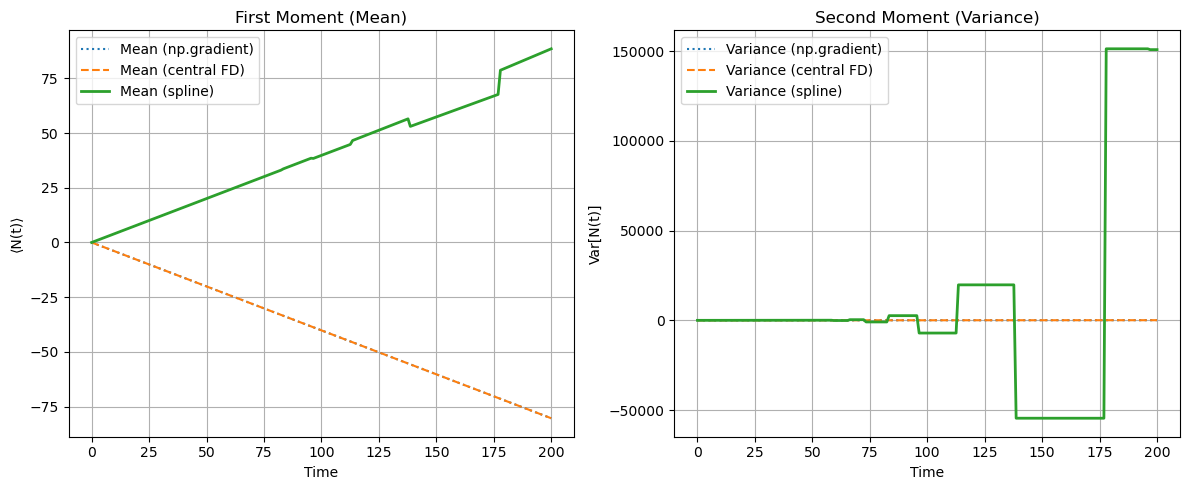

In [4]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Your setup
rhovec = qt.operator_to_vector(rhoss)

v = [-1, 1]
chi = np.linspace(-np.pi, np.pi, 1000)
d_chi = chi[1] - chi[0]
t = np.linspace(0, 200, 200)

liouvs = [tilted_liouvillian(H, c_ops, i, v) for i in chi]
rho_chi = [[qt.vector_to_operator((liou * ti).expm() * rhovec) for liou in liouvs] for ti in t]
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rho_chi])
S_chi_t = np.log(np.maximum(pchis, 1e-10))  # Avoid log(0)

ichi = 1j * chi
chi_0_index = np.argmin(np.abs(chi))

# ---------- NumPy Gradient Method (Baseline) ----------
dS_dchi_np = np.gradient(S_chi_t, ichi, axis=1)
d2S_dchi2_np = np.gradient(dS_dchi_np, ichi, axis=1)

mean_np = np.real(dS_dchi_np[:, chi_0_index])
var_np = np.real(d2S_dchi2_np[:, chi_0_index])

# ---------- Central Finite Difference ----------
mean_fd = np.zeros(len(t), dtype=float)
var_fd = np.zeros(len(t), dtype=float)

for i, S in enumerate(S_chi_t):
    # Use central difference around chi = 0
    if 1 < chi_0_index < len(chi) - 2:
        # 5-point stencil
        S_vals = S[chi_0_index - 2:chi_0_index + 3]
        mean_fd[i] = -np.imag((-S_vals[0] + 8*S_vals[1] - 8*S_vals[3] + S_vals[4]) / (12 * d_chi))
        var_fd[i] = -np.real((-S_vals[0] + 16*S_vals[1] - 30*S_vals[2] + 16*S_vals[3] - S_vals[4]) / (12 * d_chi**2))

# ---------- Spline Method ----------
mean_spline = np.zeros(len(t), dtype=float)
var_spline = np.zeros(len(t), dtype=float)

for i, S in enumerate(S_chi_t):
    spline_real = UnivariateSpline(chi, S.real, k=4, s=0)
    spline_imag = UnivariateSpline(chi, S.imag, k=4, s=0)

    dS_dchi = spline_real.derivative()(0.0) + 1j * spline_imag.derivative()(0.0)
    d2S_dchi2 = spline_real.derivative(n=2)(0.0)

    mean_spline[i] = -np.imag(dS_dchi)
    var_spline[i] = -np.real(d2S_dchi2)

# ---------- Plot ----------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, mean_np, label='Mean (np.gradient)', linestyle=':')
plt.plot(t, mean_fd, label='Mean (central FD)', linestyle='--')
plt.plot(t, mean_spline, label='Mean (spline)', linewidth=2)
plt.title("First Moment (Mean)")
plt.xlabel("Time")
plt.ylabel("⟨N(t)⟩")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t, var_np, label='Variance (np.gradient)', linestyle=':')
plt.plot(t, var_fd, label='Variance (central FD)', linestyle='--')
plt.plot(t, var_spline, label='Variance (spline)', linewidth=2)
plt.title("Second Moment (Variance)")
plt.xlabel("Time")
plt.ylabel("Var[N(t)]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


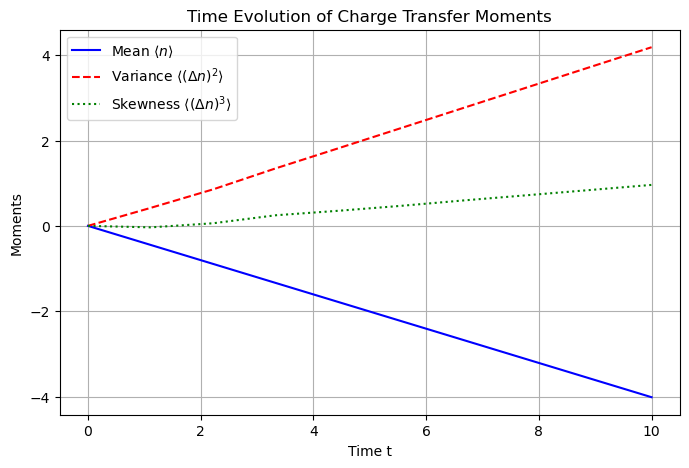

In [ ]:
# Compute vectorised density operator
rhovec = qt.operator_to_vector(rhoss)

# Create chi space
v = [-1, 1]
chi = np.linspace(-np.pi, np.pi, 1000)
d_chi = chi[1]-chi[0]

# t = [5, 15, 30, 50]
t = np.linspace(0, 10, 10)

# Compute tilted Liouvillians
liouvs = [tilted_liouvillian(H, c_ops, i, v) for i in chi]
rho_chi = [[qt.vector_to_operator((liou * ti).expm()*rhovec) for liou in liouvs] for ti in t]

# Take trace of all rhochis
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rho_chi])
# tilted_liouvillian(H, c_ops, chi[6], v)

# Compute the cumulant generating function S(chi, t) = log P(chi, t)
S_chi_t = np.log(np.maximum(pchis, 1e-10))  # Avoid log(0) errors


ichi = 1j * chi
# Compute moments by differentiation at each time step
dS_dchi = np.gradient(S_chi_t, ichi, axis=1)  # First derivative -> Mean
d2S_dchi2 = np.gradient(dS_dchi, ichi, axis=1)  # Second derivative -> Variance
d3S_dchi3 = np.gradient(d2S_dchi2, ichi, axis=1)  # Third derivative -> Skewness

# Find index for chi = 0
chi_0_index = np.argmin(np.abs(chi))

# Extract time evolution of moments
mean_n_t = np.real(dS_dchi[:, chi_0_index])
variance_n_t = np.real(d2S_dchi2[:, chi_0_index])
skewness_n_t = np.real(d3S_dchi3[:, chi_0_index])

# Plot time evolution of moments
plt.figure(figsize=(8, 5))
plt.plot(t, mean_n_t, label=r"Mean $\langle n \rangle$", color="blue")
plt.plot(t, variance_n_t, label=r"Variance $\langle (\Delta n)^2 \rangle$", color="red", linestyle="dashed")
plt.plot(t, skewness_n_t, label=r"Skewness $\langle (\Delta n)^3 \rangle$", color="green", linestyle="dotted")
plt.xlabel("Time t")
plt.ylabel("Moments")
plt.legend()
plt.title("Time Evolution of Charge Transfer Moments")
plt.grid()
plt.show()

In [54]:
from qutip.stochastic import photocurrent_mesolve


ModuleNotFoundError: No module named 'qutip.stochastic'

In [ ]:
S_chi_t.shape

(1000,)

In [3]:
# Compute vectorised density operator
rhovec = qt.operator_to_vector(rhoss)

# Create chi space
v = [-1, 1]
chi = np.linspace(-np.pi, np.pi, 1000)
d_chi = chi[1]-chi[0]

# t = [5, 15, 30, 50]
t = np.linspace(0, 20, 20)

# Compute tilted Liouvillians
liouvs = [tilted_liouvillian(H, c_ops, i, v) for i in chi]
rho_chi = [[qt.vector_to_operator((liou * ti).expm()*rhovec) for liou in liouvs] for ti in t]

# Take trace of all rhochis
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rho_chi])
# tilted_liouvillian(H, c_ops, chi[6], v)

C_chi_t = np.log(np.maximum(pchis, 1e-10))  # Avoid log(0) errors


In [13]:
C_chi_t[0][0]

np.complex128(0j)

In [4]:
C_chi = []

for Lchi in liouvs:
    eigvals = Lchi.eigenenergies()  # Returns all eigenvalues
    max_eig = eigvals[np.argmax(np.real(eigvals))]  # Pick the one with largest Re
    C_chi.append(max_eig)

C_chi = np.asarray(C_chi)

ichi = 1j * chi
first_derivative = np.gradient(C_chi, ichi)
second_derivative = np.gradient(first_derivative, ichi)

In [5]:
# Extract values at χ = 0
idx0 = np.argmin(np.abs(chi))  # Index closest to χ = 0
mean = first_derivative[idx0].real
variance = second_derivative[idx0].real

In [6]:
print("Mean =", mean)

Mean = -0.40160768937032615


In [39]:
import sympy as sm
# Define density matrix elements
rho_ee, rho_eg, rho_ge, rho_gg = sm.symbols('rho_ee, rho_eg, rho_ge, rho_gg')


# Define the density matrix
rho = sm.Matrix([[rho_ee, rho_eg], [rho_ge, rho_gg]])

# Define the imaginary unit
i = sm.I

# Define the Pauli matrices and other operators as before
sigma_x = sm.Matrix([[0, 1], [1, 0]])
sigma_y = sm.Matrix([[0, -i], [i, 0]])
sigma_z = sm.Matrix([[1, 0], [0, -1]])
sigma_plus = sm.Rational(1, 2) * (sigma_x + i * sigma_y)
sigma_minus = sm.Rational(1, 2) * (sigma_x - i * sigma_y)

# Define symbols for N tilde and gamma
N_tilde = sm.symbols('N_tilde', real=True, positive=True)  # N tilde
gamma = sm.symbols('gamma', real=True, positive=True)      # gamma

# Define D_rho expression
D_rho = (gamma * (N_tilde + 1) * (sigma_minus * rho * sigma_plus - 
           sm.Rational(1, 2) * (sigma_plus * sigma_minus * rho + rho * sigma_plus * sigma_minus)) + 
           gamma * N_tilde * (sigma_plus * rho * sigma_minus - 
           sm.Rational(1, 2) * (sigma_minus * sigma_plus * rho + rho * sigma_minus * sigma_plus)))

D_rho_epr = sm.simplify(D_rho)

# Define delta and omega as symbolic variables
Delta = sm.symbols('Delta', real=True, positive=True)
Omega = sm.symbols('Omega', real=True, positive=True)

# Define the Hamiltonian
H = sm.Rational(1, 2) * Delta * sigma_z + Omega * sigma_x

# Define the commutator of the Hamiltonian with the density matrix
H_rho_comutator = H * rho - rho * H.H

rho_evalution_expr = -i * H_rho_comutator + D_rho

rho_valid = sm.Eq((rho_ee + rho_gg), 1)

eq = sm.Eq(rho_evalution_expr, sm.zeros(2))

sol = sm.solve((eq, rho_valid), (rho_ee, rho_eg, rho_ge, rho_gg))

rho_eess = list(sol.values())[0]

J = gamma * (N_tilde - (2 * N_tilde + 1) * rho_eess)

J_s = J.simplify()
J_s0 = sm.fraction(J_s)[0]
J_s1 = sm.fraction(J_s)[1]
colect_expr = sm.collect(J_s1, gamma)
J_s1_s = sm.factor(colect_expr.coeff(gamma, 2)) * gamma**2 + sm.factor(colect_expr.coeff(gamma, 0))

J_S = J_s0 / J_s1_s
j = sm.symbols('j')
sm.Eq(j, J_S)

Eq(j, -4*Omega**2*gamma/(gamma**2*(2*N_tilde + 1)**2 + 4*(Delta**2 + 2*Omega**2)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import (
    mesolve, smesolve, steadystate, sigmax, sigmay, sigmaz, sigmam, sigmap,
    fock_dm, expect
)

# Define system parameters
gamma = 1
Omega = 1
Delta = 0
N = 0.2

# Define system operators
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sm = sigmam()
sp = sigmap()
pe = (1 + sz) / 2

# Define Hamiltonian, collapse operators, and observable list
H = 0.5 * Delta * sz + Omega * sx
c_ops = [np.sqrt(gamma * (N + 1)) * sm, np.sqrt(gamma * N) * sp]
e_ops = [pe]

# Define initial states
rho0 = fock_dm(2, 0)
rhoss = steadystate(H, c_ops)

# Compute energy eigenvalues
eigs = H.eigenenergies()

# Create time array
tf = 2000
dt = 0.001
t = np.arange(0, tf, dt)

options = {"store_measurement": True}

# Solve the stochastic master equation (homodyne detection is now the default)
result = smesolve(
    H, rho0, t, c_ops=c_ops, sc_ops=[sm], e_ops=e_ops,
    ntraj=1, options=options
)


# Extract measurement currents and expectation values
J = np.real(result.measurement[0])
pet = result.expect[0]

# Compute jump times
threshold = 0.5  # Define a threshold for detecting jumps
pp = np.diff(J) > threshold
pm = np.diff(J) < -threshold

tps = t[:-1][pp]
tms = t[:-1][pm]

# Specify jump heads and bases of positive and minus process
arrow_headp = np.ones(len(tps))
arrow_headm = np.zeros(len(tms))
arrow_basep = pet[:-1][pp]
arrow_basem = pet[:-1][pm]

# Create time windows between jumps
tfi = 15
tvs = np.sort(np.concatenate([tps, tms]))
tv0 = 0

# Arrow parameters
headw = 0.3
headl = 0.04
width = 0.05

# Create figure
fig = plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)

# Plot gaps between jumps
for tvi in tvs:
    plt.plot(t[(tv0 < t) & (t < tvi)], pet[(tv0 < t) & (t < tvi)], linewidth=3, color='k', alpha=1)
    tv0 = tvi
    if tvi > tfi:
        break

# Plot up arrows
for i in range(len(tps)):
    plt.vlines(tps[i], 0, 1, color='r', linewidth=5, alpha=0.5)
    plt.arrow(tps[i] - 0.3, 0.7, 0, 0.07, head_width=headw, head_length=headl, width=width, color=[1, 0, 0], overhang=0.1)

# Plot down arrows
for i in range(len(tms)):
    plt.vlines(tms[i], 0, 1, color='b', linewidth=5, alpha=0.5)
    plt.arrow(tms[i] + 0.3, 0.3, 0, -0.07, head_width=headw, head_length=headl, width=width, color=[0, 0, 1], overhang=0.1)

plt.grid(True, linestyle='--')
plt.yticks([0, 0.5, 1])
plt.xticks(np.arange(2, 16, 2))
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \sigma_{+}\sigma_{-}\rangle_{c}$')
plt.xlim([0, tfi])
plt.ylim([0, 1.0])

plt.subplot(3, 1, 2)
plt.plot(t[t < tfi], np.cumsum(pp.astype(int) - pm.astype(int))[t < tfi], linewidth=3, color='k')
plt.fill_between([0, tf], -7, 0, color='b', alpha=0.1)
plt.fill_between([0, tf], 0, 7, color='r', alpha=0.1)

plt.grid(True, linestyle='--')
plt.xticks(np.arange(0, 18, 2))
plt.yticks(np.arange(-6, 5, 2))
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$ N(t)$')
plt.xlim([0, tfi])
plt.ylim([-6, 6])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


100.0%. Run time:   0.00s. Est. time left: 00:00:00:00


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from FCS import TwoTimeCorrelationSS, PowerSpectrum, FCSPowerSpectrumLinear, TwoTimeCorrelation 

plt.rcParams.update({
    "text.usetex": True,
    "font.size" : 24})

In [11]:
# Define system parameters
gamma = 1
Omega = 1
Delta = 0
N = 0.2

# Define system operators
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sm = sigmam()
sp = sigmap()
pe = (1+sz)/2

# Define Hamiltonian, collapse operators, and observable list
H = 0.5 * Delta*sz + Omega*sx
c_ops = [np.sqrt(gamma*(N+1))*sm, np.sqrt(gamma*N)*sp]
e_ops = [pe]

# Define initial states
rho0 = fock_dm(2, 0)
rhoss = steadystate(H, c_ops)
# pess = expect(rhoss, sp*sm)

# Compute energy eigenvalues
eigs = H.eigenenergies()

In [12]:
# Create time array (we are using a large time since we will numerically compute the Power Spectrum too)
tf = 100
dt = 0.001;
t = np.arange(0, tf, dt)

In [13]:
result = photocurrent_mesolve(H, fock_dm(2,0), t, sc_ops=c_ops, e_ops=e_ops, store_measurement=True, noise=7)

# Get current and expectation value
J = np.real(result.measurement[0].T[0])
pet = result.expect[0]

# Get up and down events from measurement record
pp = np.real(result.measurement[0].T[1])*dt
pm = np.real(result.measurement[0].T[0])*dt

Total run time:   4.83s


In [28]:
result.measurement[0].T.shape

(2, 100000)

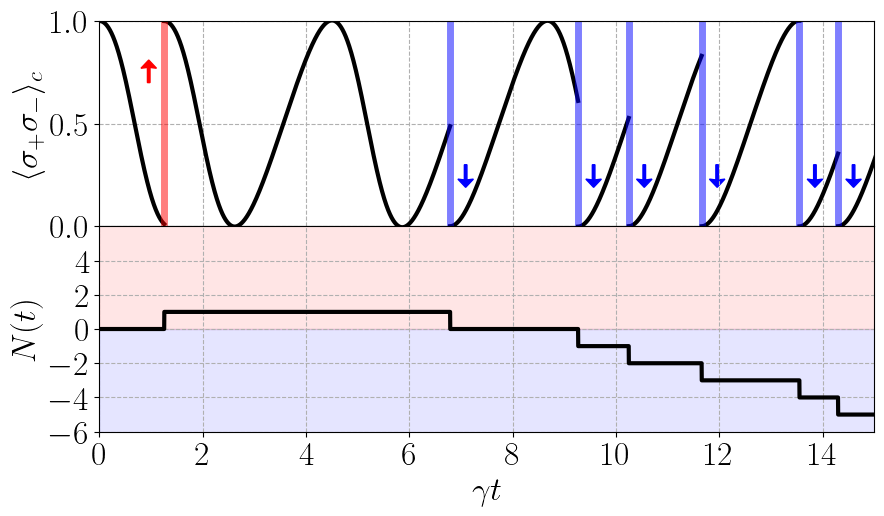

In [6]:
## Create Arrow plot between jumps. Need to get details about jumps

# Compute jump times
tps = t[pp==1]
tms = t[pm==1]

# Specify jump heads and bases of positive and minus process
arrow_headp = np.ones(len(tps))
arrow_headm = np.zeros(len(tms))
arrow_basep = pet[pp==1]
arrow_basem = pet[pm==1]

# Create time windows between jumps
tfi = 15
tvs = np.sort(np.concatenate([tps, tms]))
tvs = tvs
tv0 = 0

# Arrow parameters
headw = 0.3
headl = 0.04
width = 0.05

# Create figure
fig = plt.figure(figsize=(10, 8))
plt.subplot(3, 1,1)

# Create time windows between jumps
tfi = 15
tvs = np.sort(np.concatenate([tps, tms]))
tvs = tvs
tv0 = 0

# Arrow parameters
headw = 0.3
headl = 0.04
width = 0.05

# Plot gaps between jumps
for tvi in tvs:
    
    plt.plot(t[(tv0<t)&(t<tvi)], pet[(tv0<t)&(t<tvi)], linewidth=3, color='k', alpha=1)
    tv0 = tvi
    
    if tvi > tfi:
        break
    
# Plot up arraos
for i in range(len(tps)):
    plt.vlines(tps[i], 0, 1, color='r', linewidth=5, alpha=0.5)
    plt.arrow(tps[i]-0.3, 0.7, 0, 0.07, head_width=headw, head_length=headl, width=width, color=[1,0,0], overhang=0.1)

# Plot down arrows
for i in range(len(tms)):
    plt.vlines(tms[i], 0, 1, color='b', linewidth=5, alpha=0.5)
    plt.arrow(tms[i]+0.3, 0.3, 0, -0.07, head_width=headw, head_length=headl, width=width, color=[0,0,1], overhang=0.1)
    

plt.grid(True, linestyle='--')
plt.yticks([0, 0.5, 1])
plt.xticks(np.arange(2, 16, 2))
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \sigma_{+}\sigma_{-}\rangle_{c}$')
plt.xlim([0, tfi])
plt.ylim([0,1.0])


plt.subplot(3, 1,2)
plt.plot(t[t<tfi], np.cumsum(pp - pm)[t<tfi], linewidth=3, color='k')
plt.fill_between([0, tf], -7, 0, color='b', alpha=0.1)
plt.fill_between([0, tf], 0, 7, color='r', alpha=0.1)

plt.grid(True, linestyle='--')

plt.xticks(np.arange(0, 18, 2))
plt.yticks(np.arange(-6, 5, 2))
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$ N(t)$')
plt.xlim([0, tfi])
plt.ylim([-6,6])

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [9]:
J.shape

(100000,)